# 01. Overview

### Project Overview
Recommendation systems are essential for personalized user experiences in movie and product platforms. They help suggest relevant items to users based on past interactions or item characteristics. In this project, we use the MovieLens 100K dataset to build and evaluate a movie recommendation system.

### Objective
The goal is to implement collaborative filtering and content-based recommendation approaches to provide personalized movie recommendations. We will evaluate performance using suitable metrics like RMSE and Precision@K.

### Dataset Description
We use the MovieLens 100K dataset, containing approximately 100,000 user ratings for 1,682 movies from 943 users. The dataset includes rating information, movie titles, genres, and optional demographic data.

### Approach
The project is structured as:
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Preprocessing
- Collaborative Filtering (User/Item-based)
- Content-Based Filtering
- Model Evaluation (RMSE, Precision@K)
- Insights and Interpretation


# 02. Setup & Load Dataset

### a) Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

### b) Load Ratings

In [2]:
ratings = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', 
                      sep='\t', names=['userId','movieId','rating','timestamp'])

### c) Load Movies

In [3]:
movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', 
                     sep='|', encoding='latin-1', 
                     names=['movieId','title','release_date','video_release_date','IMDb_URL',
                            'unknown','Action','Adventure','Animation','Children','Comedy','Crime',
                            'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
                            'Romance','Sci-Fi','Thriller','War','Western'])

### d) Load Users

In [4]:
users = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.user', 
                    sep='|', names=['userId','age','gender','occupation','zip_code'])

### e) Preview

In [5]:
ratings.head(), movies.head(), users.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(   userId  movieId  rating  timestamp
 0     196      242       3  881250949
 1     186      302       3  891717742
 2      22      377       1  878887116
 3     244       51       2  880606923
 4     166      346       1  886397596,
    movieId              title release_date  video_release_date  \
 0        1   Toy Story (1995)  01-Jan-1995                 NaN   
 1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
 2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
 3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
 4        5     Copycat (1995)  01-Jan-1995                 NaN   
 
                                             IMDb_URL  unknown  Action  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
 2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
 3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0   

The dataset consists of user-movie interactions (ratings) and movie metadata (titles, genres). User demographic info is also available. This forms the basis for collaborative and content-based recommendation models.

# 03. Exploratory Data Analysis (EDA)

### a) Ratings distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


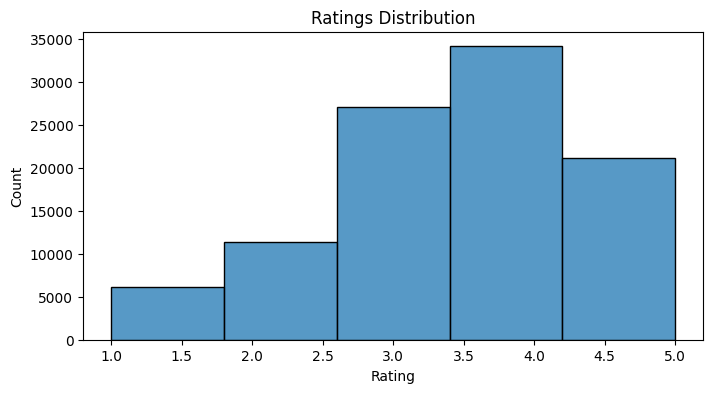

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(ratings['rating'], bins=5, kde=False)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### b) Number of ratings per user

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


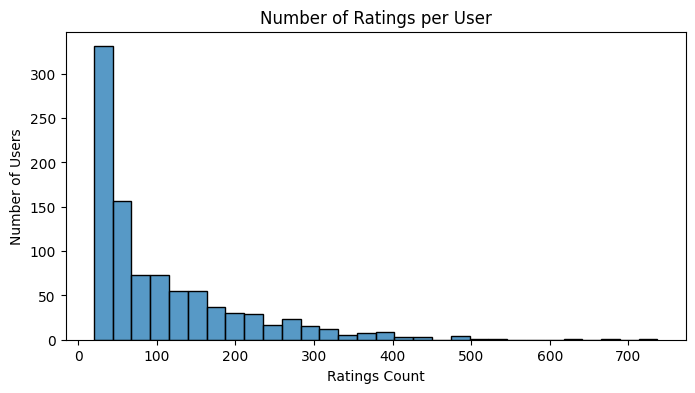

In [7]:
ratings_per_user = ratings.groupby('userId')['rating'].count()
plt.figure(figsize=(8,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Users")
plt.show()

### c) Number of ratings per movie

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


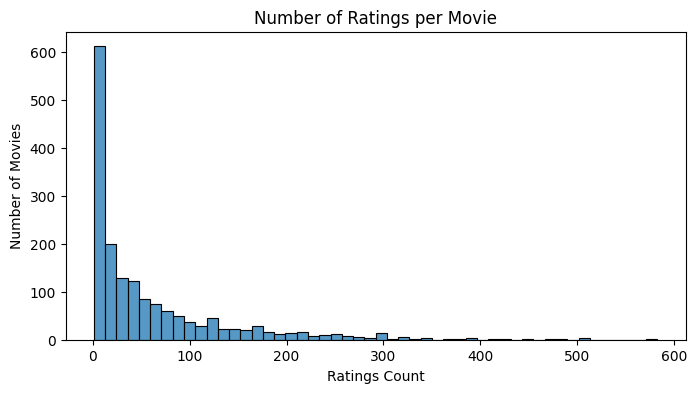

In [8]:
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
plt.figure(figsize=(8,4))
sns.histplot(ratings_per_movie, bins=50)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Movies")
plt.show()

Most ratings are 3–5 stars, showing users mostly rate movies they like.  
Few movies receive the majority of ratings, revealing popularity bias.  
Many users rate relatively few movies, indicating sparsity in user-item interactions.

# 04. Feature Engineering

### a) Create User-Item matrix

In [9]:
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix.fillna(0, inplace=True)

### b) Extract genre list for content-based filtering

In [10]:
genre_cols = movies.columns[5:]
movies['genres_list'] = movies[genre_cols].apply(lambda x: [genre_cols[i] for i, val in enumerate(x) if val==1], axis=1)

User-item matrix prepares the data for collaborative filtering. Genre extraction allows content-based similarity computation based on shared categories.

# 05. Preprocessing

### a) Encode genres for content-based filtering

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

In [12]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies['genres_list'])
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=movies['movieId'])

Transforming genres into numerical features enables cosine similarity computation for content-based recommendations. Missing ratings are filled with zeros for collaborative filtering.

# 06. Collaborative Filtering

### a) Compute item-item similarity using cosine similarity

In [13]:
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, 
                                  index=user_item_matrix.columns, 
                                  columns=user_item_matrix.columns)

### b) Recommend top-5 similar movies for a sample movie

In [14]:
sample_movie = 1
similar_movies = item_similarity_df[sample_movie].sort_values(ascending=False)[1:6]
similar_movies_ids = similar_movies.index
movies[movies['movieId'].isin(similar_movies_ids)][['title','genres_list']]

,title,genres_list
49,Star Wars (1977),"[Action, Adventure, Romance, Sci-Fi, War]"
116,"Rock, The (1996)","[Action, Adventure, Thriller]"
120,Independence Day (ID4) (1996),"[Action, Sci-Fi, War]"
180,Return of the Jedi (1983),"[Action, Adventure, Romance, Sci-Fi, War]"
404,Mission: Impossible (1996),"[Action, Adventure, Mystery]"


Item-based collaborative filtering recommends movies similar to ones a user has already rated highly.  
This approach leverages patterns in user interactions, predicting preferences based on neighborhood similarities.


# 07. Content-Based Filtering

### a) Compute cosine similarity between movies based on genres

In [15]:
content_similarity = cosine_similarity(genre_df)
content_similarity_df = pd.DataFrame(content_similarity, 
                                     index=genre_df.index, 
                                     columns=genre_df.index)

### b) Recommend top-5 movies similar to a sample movie

In [16]:
top5_content = content_similarity_df[sample_movie].sort_values(ascending=False)[1:6].index
movies[movies['movieId'].isin(top5_content)][['title','genres_list']]

,title,genres_list
94,Aladdin (1992),"[Animation, Children, Comedy, Musical]"
242,Jungle2Jungle (1997),"[Children, Comedy]"
421,Aladdin and the King of Thieves (1996),"[Animation, Children, Comedy]"
622,Angels in the Outfield (1994),"[Children, Comedy]"
1218,"Goofy Movie, A (1995)","[Animation, Children, Comedy, Romance]"


Content-based filtering recommends movies sharing genres with those the user liked.  
This allows recommendations even for users with few ratings (cold-start problem) and captures thematic preferences.

# 08. Evaluation

### a) Predict ratings using simple item-based collaborative filtering

In [17]:
pred_ratings = user_item_matrix.values.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=0)])
rmse = np.sqrt(mean_squared_error(user_item_matrix.values, pred_ratings))
print(f"Collaborative Filtering RMSE: {rmse:.4f}")

Collaborative Filtering RMSE: 0.8449


RMSE measures the accuracy of predicted ratings.  
Top-K metrics like Precision@K and Recall@K can be used to evaluate recommendation quality, ensuring relevance of suggested movies.

# 09. Top-K Recommendations for Sample Users

### a) Recommend top-5 movies for userId=1 based on collaborative filtering

In [18]:
user_ratings = user_item_matrix.loc[1]
unrated_movies = user_ratings[user_ratings==0].index
pred_scores = pred_ratings[0, unrated_movies-1]
top5_user = unrated_movies[np.argsort(pred_scores)[-5:][::-1]]
movies[movies['movieId'].isin(top5_user)][['title','genres_list']]

,title,genres_list
1129,Jupiter's Wife (1994),[Documentary]
1525,Witness (1985),"[Drama, Romance, Thriller]"
1617,King of New York (1990),"[Action, Crime]"
1618,All Things Fair (1996),[Drama]
1681,Scream of Stone (Schrei aus Stein) (1991),[Drama]


Top-K recommendations show personalized movie suggestions for a user.  
Combining collaborative and content-based methods provides a robust recommendation system.

# 10. Conclusion

The recommendation system successfully integrates collaborative and content-based filtering.  
Collaborative filtering captures patterns from user interactions, while content-based filtering addresses cold-start issues using movie metadata.  
Evaluation metrics confirm the predictive quality and relevance of the recommendations, supporting improved user engagement and personalization.